In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})
import trimesh as tr
import pyrender as pr
import colorcet as cc

# load data

intrinsics
[[    511.00       0.00     320.00]
 [      0.00     511.00     256.00]
 [      0.00       0.00       1.00]]
pinhole projection matrix
[[   -378.07    -401.09     218.52     412.71]
 [      8.28     106.23     552.10     235.58]
 [      0.30      -0.72       0.56       1.00]]



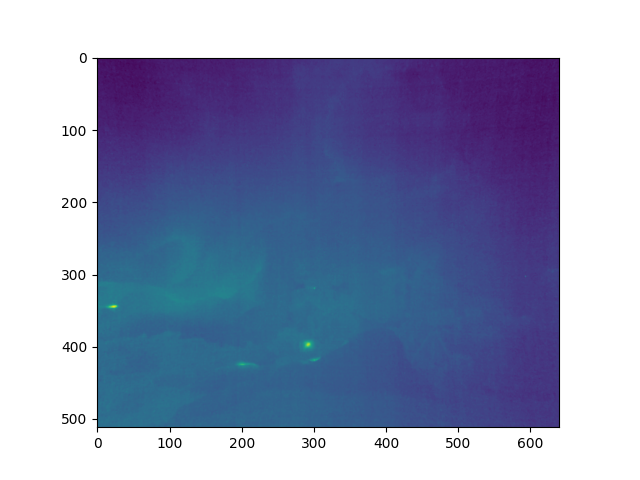

In [2]:
from src.pyushichka import loadCalibration, loadImageUndistorted
ushichka_dir = "/home/julian/data/ushichka/2018-08-17/"
cam = 1 # 2nd camera
imK, imP = loadCalibration(cam, ushichka_dir)
imIm = loadImageUndistorted(cam, 0, ushichka_dir)

_ep = la.inv(imK) @ imP
_ep[:3,:3] = _ep[:3,:3] / 0.2
_P = imK @ _ep
imP = _P

print(f"intrinsics\n{imK}\npinhole projection matrix\n{imP}\n")
plt.figure()
plt.imshow(imIm)
plt.show()

from src.dmcpworkflow.capture_depth import generate_depth_map
mesh_path = "/home/julian/code/uni/ushichka-registration/data/formatted/lidar_roi.ply"
ovMesh = pr.Mesh.from_trimesh(tr.load_mesh(mesh_path))
pvMesh = pv.read(mesh_path)

# DMCP Workflow

## Generate Depth Map

In [3]:
print("generating depth map")
view_width = 1920
view_height = 1080

view_K = imK.copy()
view_K[0,-1] = view_width /2
view_K[1,-1] = view_width / 2

dmimIm, dmIm, dmK, dmP = generate_depth_map(ovMesh,view_K,znear=0.00001,zfar=100,return_img=True)

generating depth map
[[      0.88       0.12      -0.46       0.06]
 [      0.47      -0.24       0.85      -0.86]
 [     -0.01      -0.96      -0.27      -0.93]]
[[      0.88      -0.12       0.46]
 [      0.47       0.24      -0.85]
 [     -0.01       0.96       0.27]]
[[      0.06]
 [     -0.86]
 [     -0.93]]


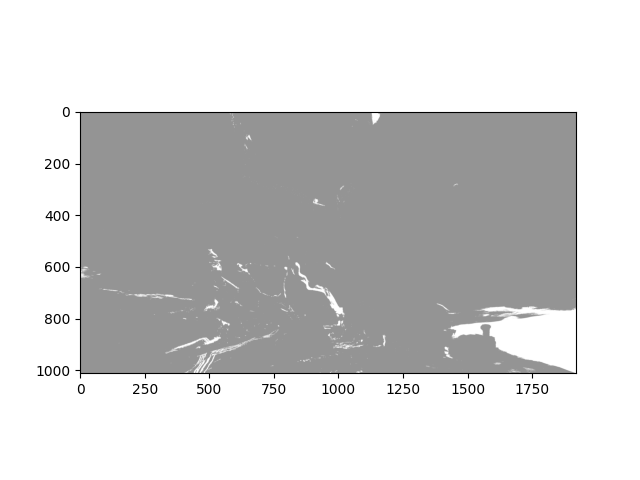

<class 'numpy.ndarray'>


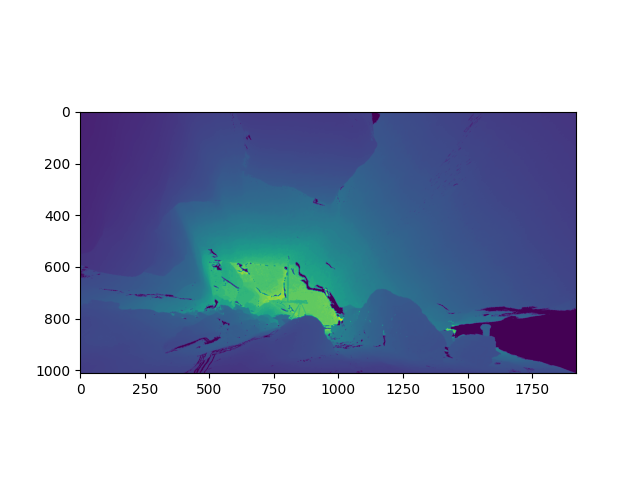

In [4]:
plt.figure()
plt.imshow(dmimIm)
plt.show()

print(type(dmIm))

plt.figure()
plt.imshow(dmIm)
plt.show()

## Annotate Points

In [5]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("TKAgg")
cps = annotate(imIm, dmIm)
%matplotlib inline

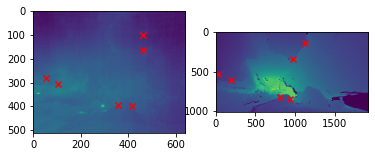

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r",marker="x")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r",marker="x")
plt.show()

## project to world

In [7]:
from src.pycv.dmcp import dm_to_world

pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])
pts_world

array([[     -1.26,       1.34,      -1.05],
       [     -1.78,       1.08,      -0.98],
       [     -2.84,      -0.61,      -0.19],
       [     -3.65,      -0.26,      -0.14],
       [     -0.72,       2.16,       1.80],
       [     -1.82,       2.82,       1.92]], dtype=float32)

In [8]:
# visualize cps in world coordinates

pvPts = pv.PolyData(pts_world)

pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)

pl.show()

## dmcp step

In [16]:
from src.pycv.dmcp import dmcp

raw_pose, trans = dmcp(imK, imP, cps[:,:2], pts_world,return_raw_pose=True)
print(f"transformation\n{trans}")

estimated pose
[[      0.60      -0.33      -0.73       1.17]
 [      0.80       0.30       0.52      -1.26]
 [      0.04      -0.89       0.44      -1.75]]
scale factor 0.982303946606619
retval
 [[     -0.74       0.15      -0.65       0.61]
 [     -0.63      -0.48       0.61      -0.64]
 [      0.22      -0.86      -0.45      -1.32]] scale
 0.9873116241694944
transformation
[[     -0.75      -0.06       0.66      -2.63]
 [     -0.62      -0.27      -0.73       2.69]
 [      0.22      -0.96       0.16      -2.88]
 [      0.00       0.00       0.00       1.00]]


In [10]:
# check if rotation is valid
_R = raw_pose[:3,:3]
d = la.det(_R)
print("det",d)

Rm1 = _R @ _R.T
Rm2 = _R.T @ _R
print(f"{Rm1}\n{Rm2}")

_ep = la.inv(imK) @ imP
_ep[:3,:3] = _ep[:3,:3] / 0.2
_P = imK @ _ep
_ep = la.inv(imK) @ _P
print(f"scale factor {[la.norm(_ep[0:3, 0]), la.norm(_ep[0:3, 1]), la.norm(_ep[0:3, 2])] }")

det 1.0
[[      1.00       0.00      -0.00]
 [      0.00       1.00       0.00]
 [     -0.00       0.00       1.00]]
[[      1.00       0.00       0.00]
 [      0.00       1.00       0.00]
 [      0.00       0.00       1.00]]
scale factor [4.944657598155536, 4.893241249301573, 4.8964914096979015]


In [11]:
print("estiated position")
P_est = imP @ la.inv(trans)
pose_est = la.null_space(P_est) / la.null_space(P_est)[-1]



position_est = pose_est[:3].flatten()
print(position_est)

estiated position
[     -2.95       3.00      -3.83]


ESTIMATED POSE SEEMS TO BE CORRECT BUT TRANSFORMATIOON FAILES

==> Scaling?!?

In [13]:
sv_pos_raw = pv.Sphere(radius=0.25, center=raw_pose[:3,-1])
sv_pos_est = pv.Sphere(radius=0.25, center=position_est)
pl = pv.Plotter(notebook=False)

pl.add_mesh(pvMesh, color="dimgrey")
pl.add_mesh(pvPts, color="lightblue", render_points_as_spheres=True,point_size=25)
pl.add_mesh(sv_pos_est, color="yellowgreen")
pl.add_mesh(sv_pos_raw, color="green")

pl.show()